In [1]:
from typing import List, Tuple, Dict, Union, Callable

import os
import sys
sys.path.append("..")

import multiprocessing as mp

import glob
import pathlib

import tqdm
tqdm.tqdm.pandas()

import json

import re

import numpy as np
import pandas as pd

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from src.misc import paths, utc_to_date
from src.topic import Top2VecViewer, generate_wordcloud
from src.classifiers import make_setfit_binary_predictor
from src.text import tokenize_text, normalize_text, text_to_sentences, get_similar_words_fasttext

## __Load Transcript Dataset__

In [2]:
class TranscriptLoader:

    @property
    def id_columns(self) -> List[str]:
        return ["company_id", 
                "company_name", 
                "headline", 
                "most_important_date_utc",
                "key_dev_id",
                "transcript_id",
                "transcript_collection_type_name",
                "transcript_presentation_type_name",
                "symbol"]

    def load(self):

        # Load metadata
        meta_file = "largest_mining_companies_by_market_cap_with_filing_ciq_id_with_transcript.csv"
        df_meta = pd.read_csv(paths.meta / meta_file)
        
        # Load transcripts
        df_trans = []
        pt_trans = glob.glob(str(paths.transcripts / "raw" / "*.json"))
        for p in tqdm.tqdm(pt_trans, desc="Loading transcripts"):
            df_trans.append(pd.read_json(p))
        df_trans = pd.concat(df_trans, ignore_index=True)

        # UTC time to date
        df_trans["most_important_date_utc"] = df_trans["most_important_date_utc"].map(utc_to_date)

        # Keep executive utterances only
        mask_exe = df_trans["speaker_type_name"] == "Executives"
        df_trans = df_trans.loc[mask_exe]

        # Join with meta data on `company_id` to get company symbol
        df_trans = pd.merge(df_trans, df_meta[["ciq_company_id", "symbol"]],
                            how="left", 
                            left_on="company_id", 
                            right_on="ciq_company_id")
        
        # Text processing
        print("Cleaning and splitting utterances into sentences...")
        df_trans["component_text_sentences"] = \
            df_trans["component_text"].progress_apply(lambda x: text_to_sentences(normalize_text(x)))
        
        df_trans = df_trans.loc[df_trans["component_text_sentences"].map(len) > 0]
        return df_trans
    
    def flush_processed(self, df: pd.DataFrame, name: str) -> pd.DataFrame:
        df.to_json(paths.transcripts / "processed" / name, 
                   orient="records",
                   indent=4)
        return df
    
    def load_processed(self, name: str) -> pd.DataFrame:
        df = pd.read_json(paths.transcripts / "processed" / name,
                          orient="records")
        return df


transcript_loader = TranscriptLoader()

In [3]:
FROM_PROCESSED = True
if FROM_PROCESSED:
    df_transcript = transcript_loader.load_processed("transcript_with_attributes.json")
else:
    df_transcript = transcript_loader.load()
df_transcript.head()

,company_id,company_name,headline,most_important_date_utc,key_dev_id,transcript_id,transcript_collection_type_name,transcript_presentation_type_name,transcript_component_id,component_order,...,transcript_person_id,transcript_person_name,speaker_type_name,component_text,ciq_company_id,symbol,component_text_sentences,topic_ids,is_noise_probas,is_action_probas
0,191781,Alumina Limited,"Alumina Ltd., 2009 Earnings Call, Feb-09-2010",2010-02-09,109404907,93580,Proofed Copy,Final,6539093,0,...,170977,John Bevan,Executives,"Good morning, everybody, and thank you for joi...",191781,AWC.AX,"[Good morning, everybody, and thank you for jo...","[[13], [6, 8], [0, 9], [0, 4], [15], [4], [4, ...","[0.9459135625, 0.9481500873, 0.9489170359, 0.9...","[0.5172947680000001, 0.6331970266, 0.484037141..."
1,191781,Alumina Limited,"Alumina Ltd., 2009 Earnings Call, Feb-09-2010",2010-02-09,109404907,93580,Proofed Copy,Final,6539094,1,...,170978,Judith Downes,Executives,"Thank you, John. Turning now to the financial ...",191781,AWC.AX,"[Turning now to the financial statements., Alu...","[[15], [4, 12], [0, 10], [10], [12, 14], [0, 3...","[0.9500789177000001, 0.0242401299, 0.025832092...","[0.11794425060000001, 0.0072522827, 0.02841341..."
2,191781,Alumina Limited,"Alumina Ltd., 2009 Earnings Call, Feb-09-2010",2010-02-09,109404907,93580,Proofed Copy,Final,6539095,2,...,170977,John Bevan,Executives,"Thank you, Judith. The demand for aluminium is...",191781,AWC.AX,[The demand for aluminium is returning from it...,"[[4], [12], [10], [5], [7], [10], [14], [5, 6]...","[0.023892272000000003, 0.18873080920000002, 0....","[0.0166476354, 0.0176607635, 0.0127187778, 0.0..."
3,191781,Alumina Limited,"Alumina Ltd., 2009 Earnings Call, Feb-09-2010",2010-02-09,109404907,93580,Proofed Copy,Final,6539098,5,...,170977,John Bevan,Executives,"Sure, we expect the Alumar refinery to be runn...",191781,AWC.AX,"[Sure, we expect the Alumar refinery to be run...","[[10], [10], [-1], [7]]","[0.0247579201, 0.0244771968, 0.0244255078, 0.0...","[0.051134784100000004, 0.0785641464, 0.0272386..."
4,191781,Alumina Limited,"Alumina Ltd., 2009 Earnings Call, Feb-09-2010",2010-02-09,109404907,93580,Proofed Copy,Final,6539100,7,...,170977,John Bevan,Executives,"Not Suralco, no. The Alumar refinery will be r...",191781,AWC.AX,[The Alumar refinery will be ramped back again...,"[[10], [5], [-1]]","[0.0243097034, 0.9440162228000001, 0.0258065851]","[0.019547777000000002, 0.0447588824, 0.0409643..."


## __Assign Attributes to Earning's Call Transcripts__

### __Get Topic IDs__

In [4]:
# This global variable is also used in the `compute_statistics` function
topic_stoi_cluster = {
    # "environmental_regulation": 2,
    "customer_orientation":     4,
    "shareholder_affiliation":  6,
    "hiring_employees":         8,
    "natural_disaster":         9,
    "litigation":               11,
    "carbon_emissions":         12,
    "labor_issues":             13,
    "supply_chain_problems":    14,
    "taxes":                    15
}
topic_stoi_pillar = {
    "environmental": 0,
    "social":        1,
    "governance":    2,
}

topic_itos_cluster = {v: k for k, v in topic_stoi_cluster.items()}
topic_itos_pillar = {v: k for k, v in topic_stoi_pillar.items()}

id_map_cluster = list(topic_itos_cluster.keys())
id_map_pillar = list(topic_itos_pillar.keys())

In [5]:
t2v_viewer = Top2VecViewer.load(paths.t2v / "doc2vec-deep-learn-16-topics.pkl")

In [6]:
# Pair topic words with their scores
#   We will trim the topic words to keep only the relevant
#   ones for the topic using domain knowledge
topic_words = t2v_viewer.get_topic_words(topic_itos_cluster.keys(), top_k=25)
topic_words.loc[:, "topic_name"] = topic_words["topic_num"].map(lambda i: topic_itos_cluster[i])
topic_words.head()

,topic_num,keyword,cosine_score,topic_name
0,4,customer,0.4407,customer_orientation
1,4,demand,0.3292,customer_orientation
2,4,sale,0.3236,customer_orientation
3,4,margin,0.3184,customer_orientation
4,4,revenue,0.3043,customer_orientation


In [7]:
# Load trimmed topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_aj_th.csv")
topic_words = topic_words.loc[topic_words["suggest_delete_any"] != 1]
topic_words.head()

,topic_num,keyword,suggest_delete_anne,suggest_delete_tony,suggest_delete_any,suggest_delete_both,cosine_score,topic_name
0,4,customer,NaN,NaN,NaN,NaN,0.4407,customer_orientation
1,4,demand,NaN,NaN,NaN,NaN,0.3292,customer_orientation
2,4,sale,NaN,NaN,NaN,NaN,0.3236,customer_orientation
3,4,margin,NaN,NaN,NaN,NaN,0.3184,customer_orientation
4,4,revenue,NaN,NaN,NaN,NaN,0.3043,customer_orientation


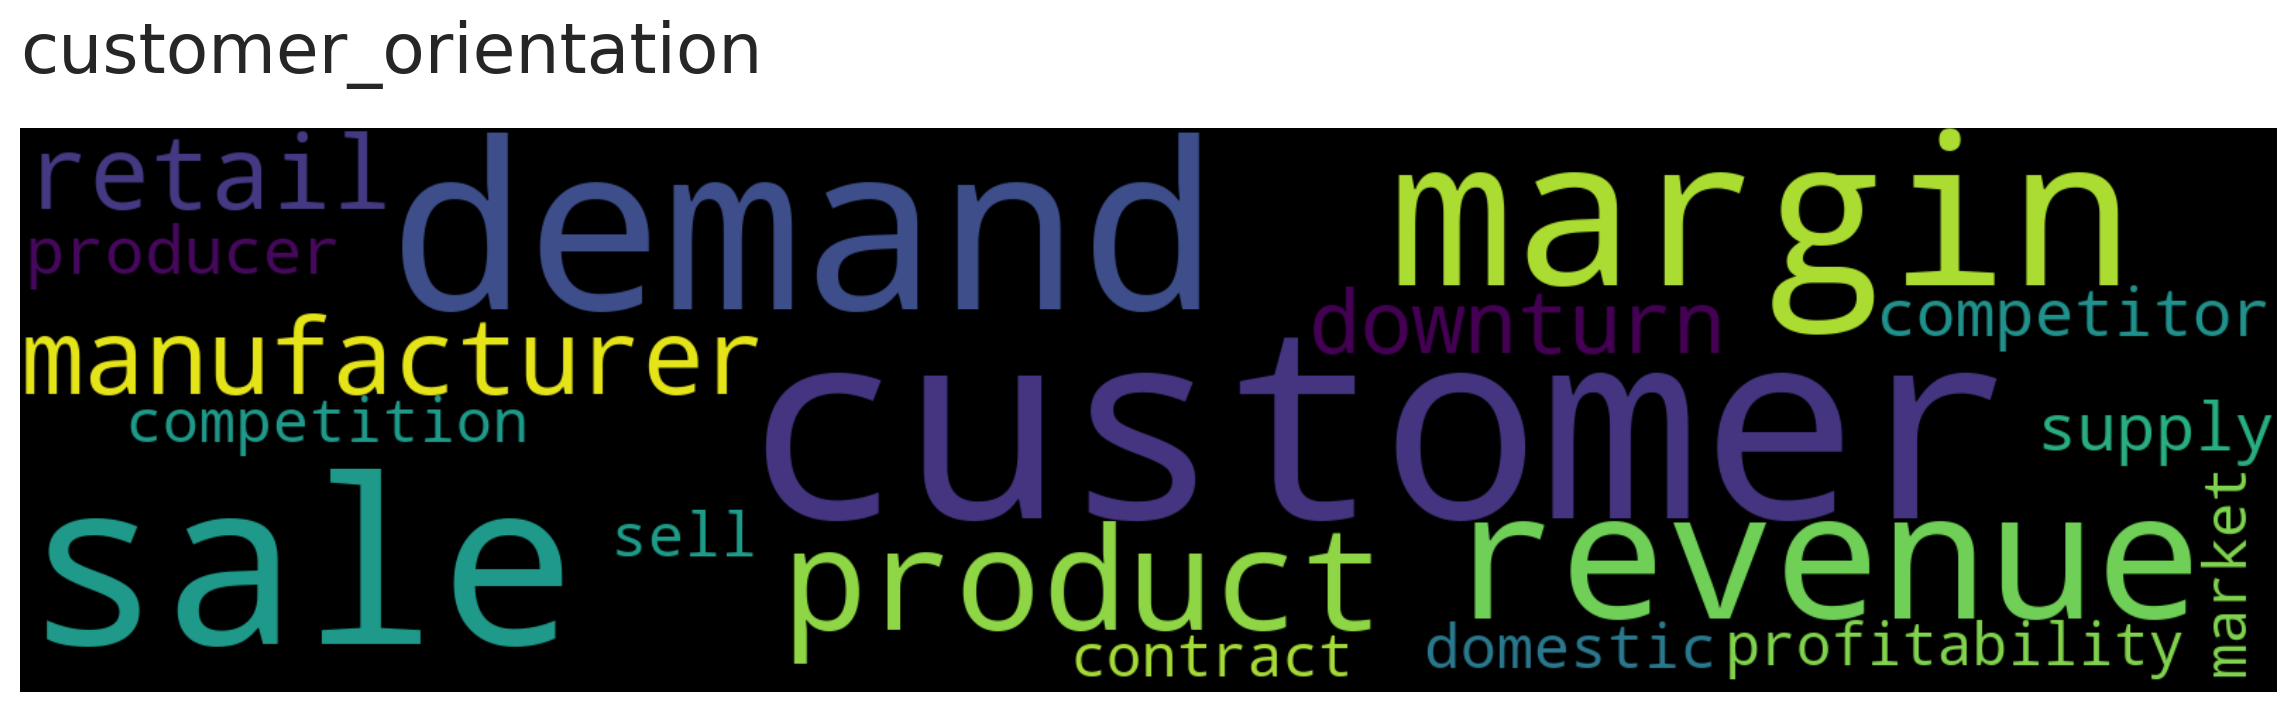

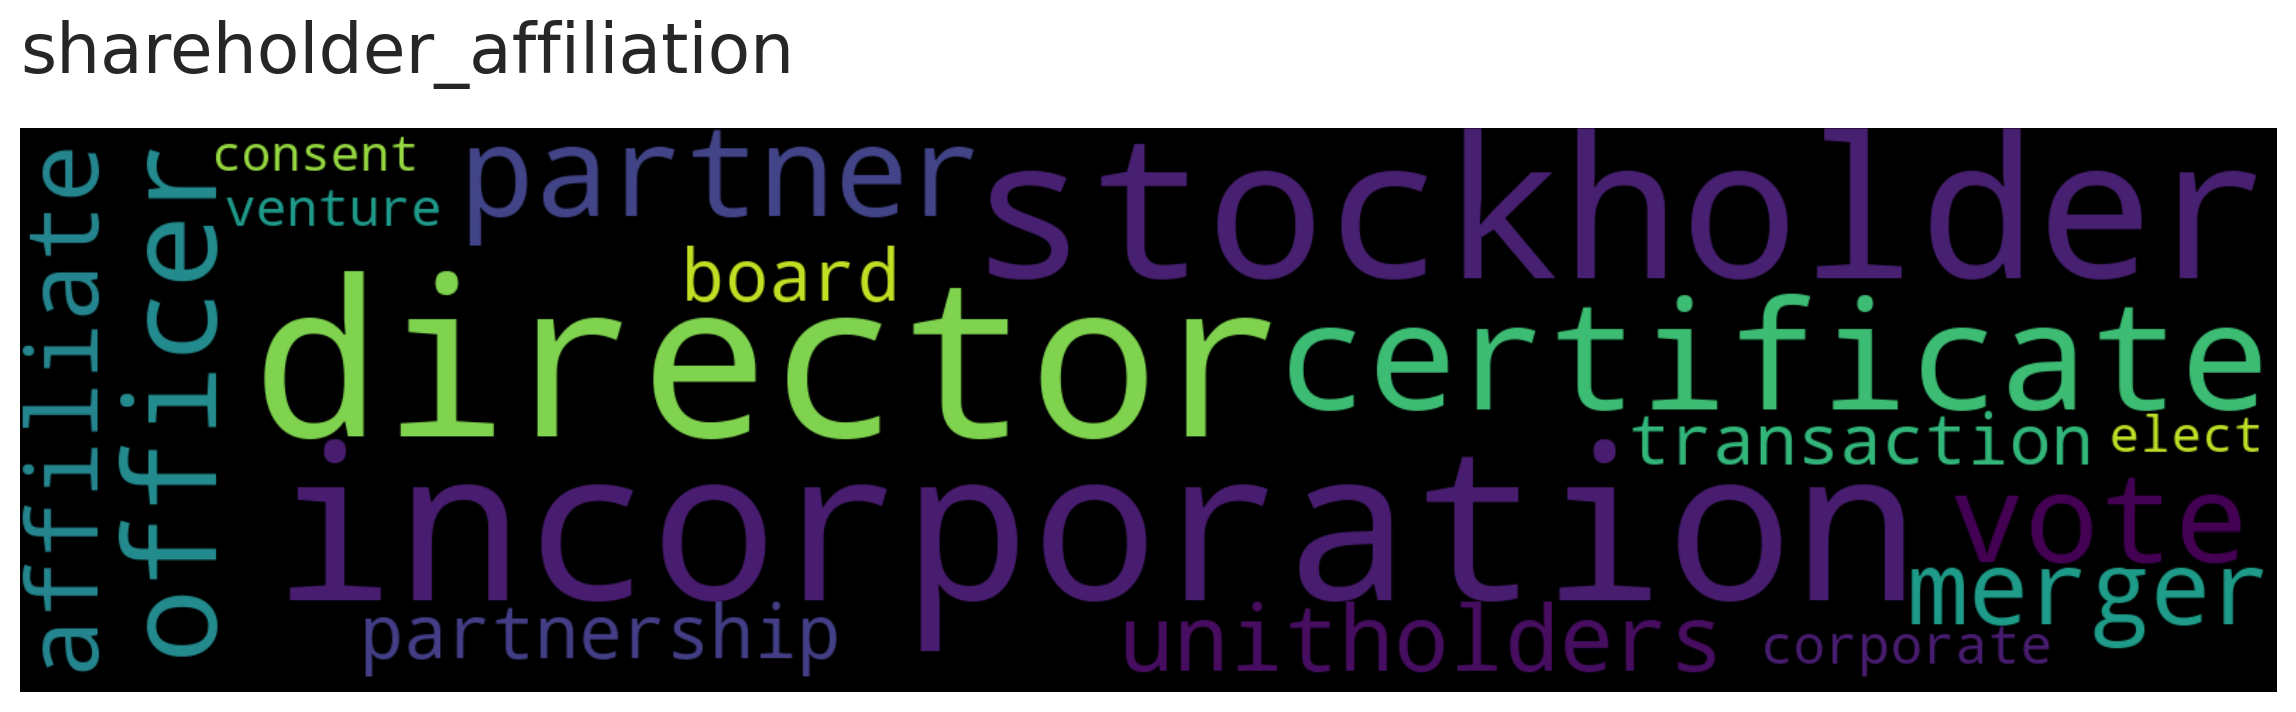

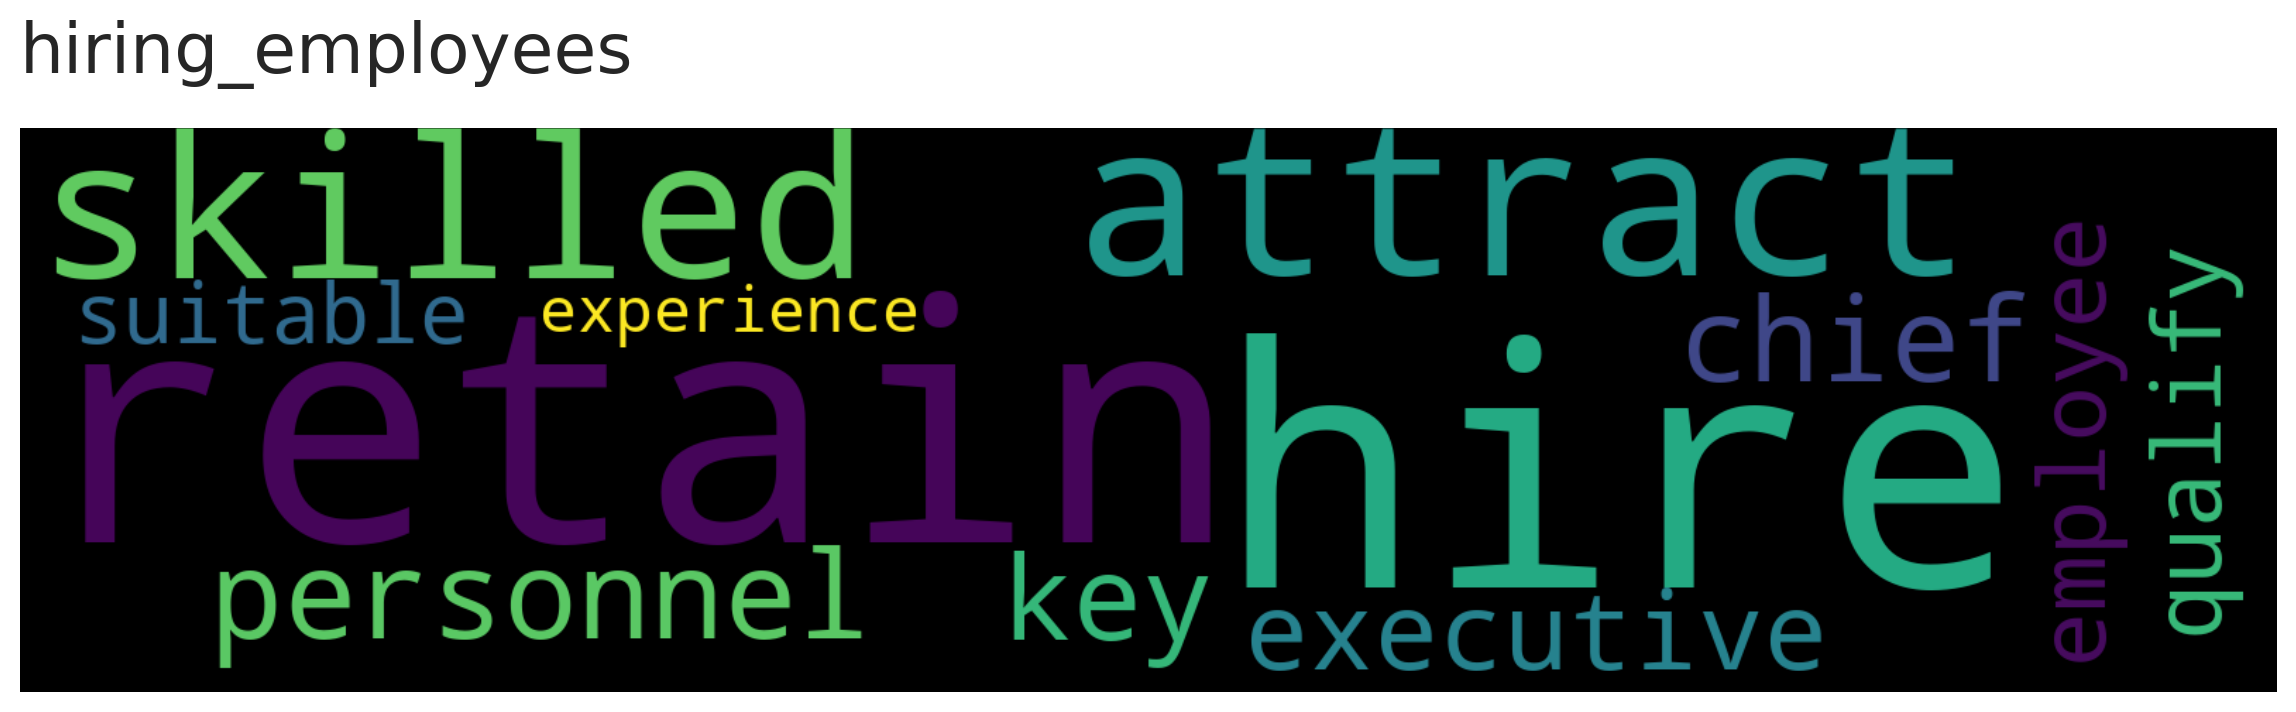

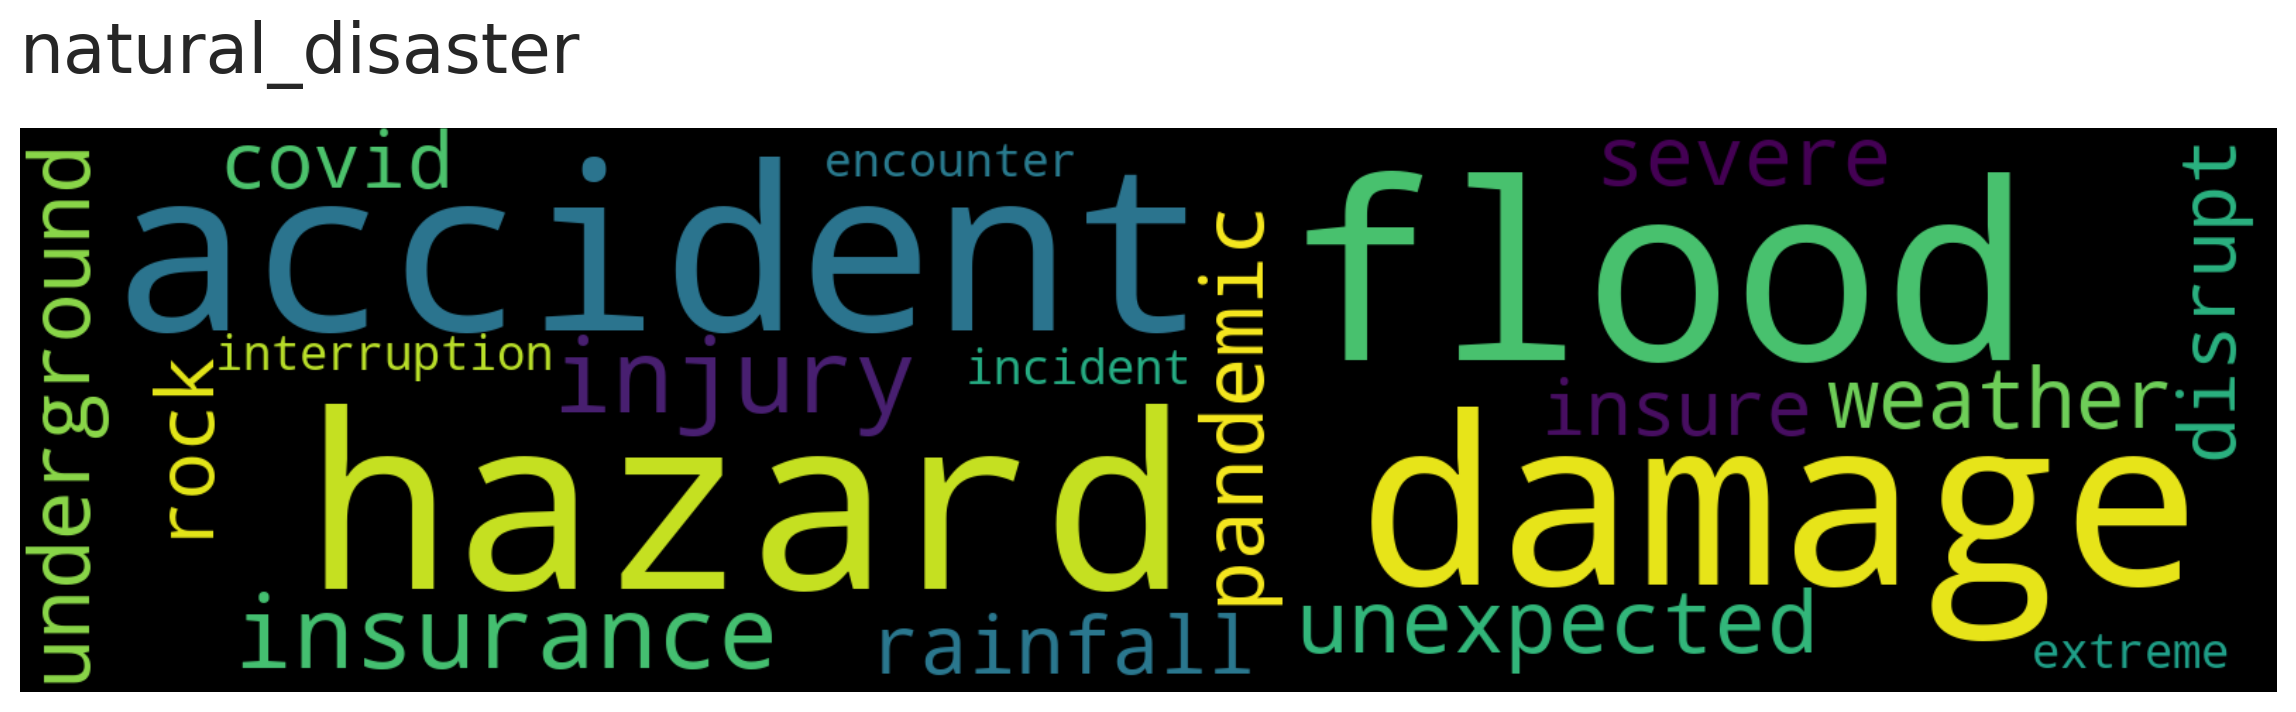

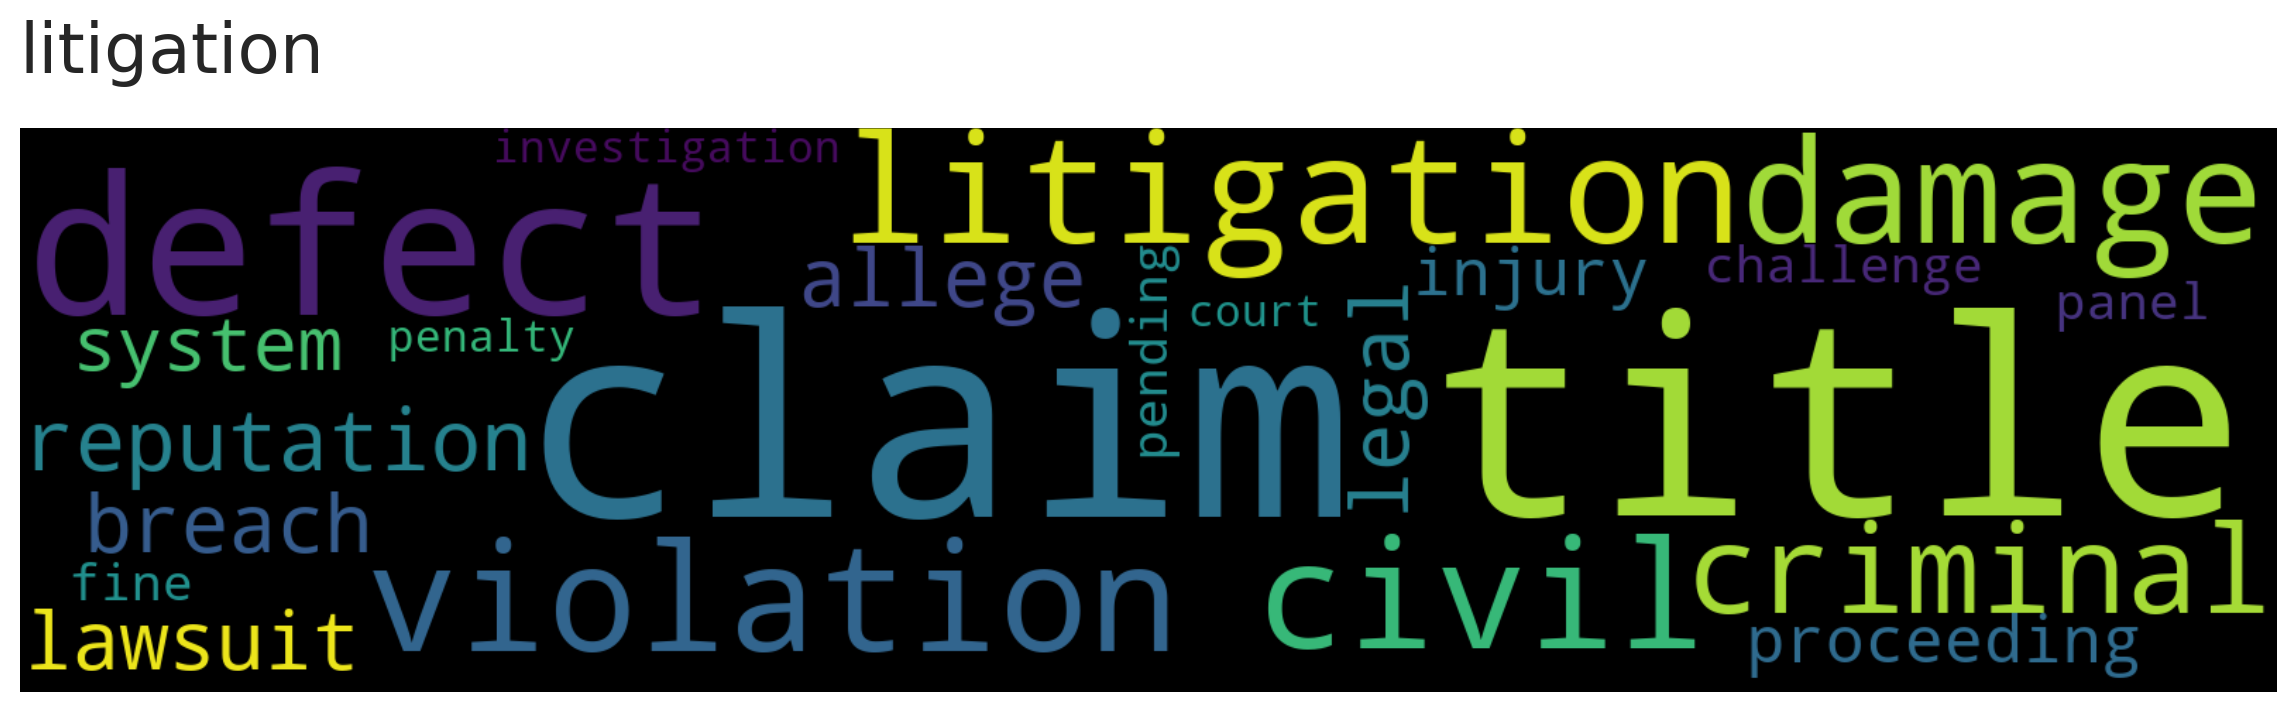

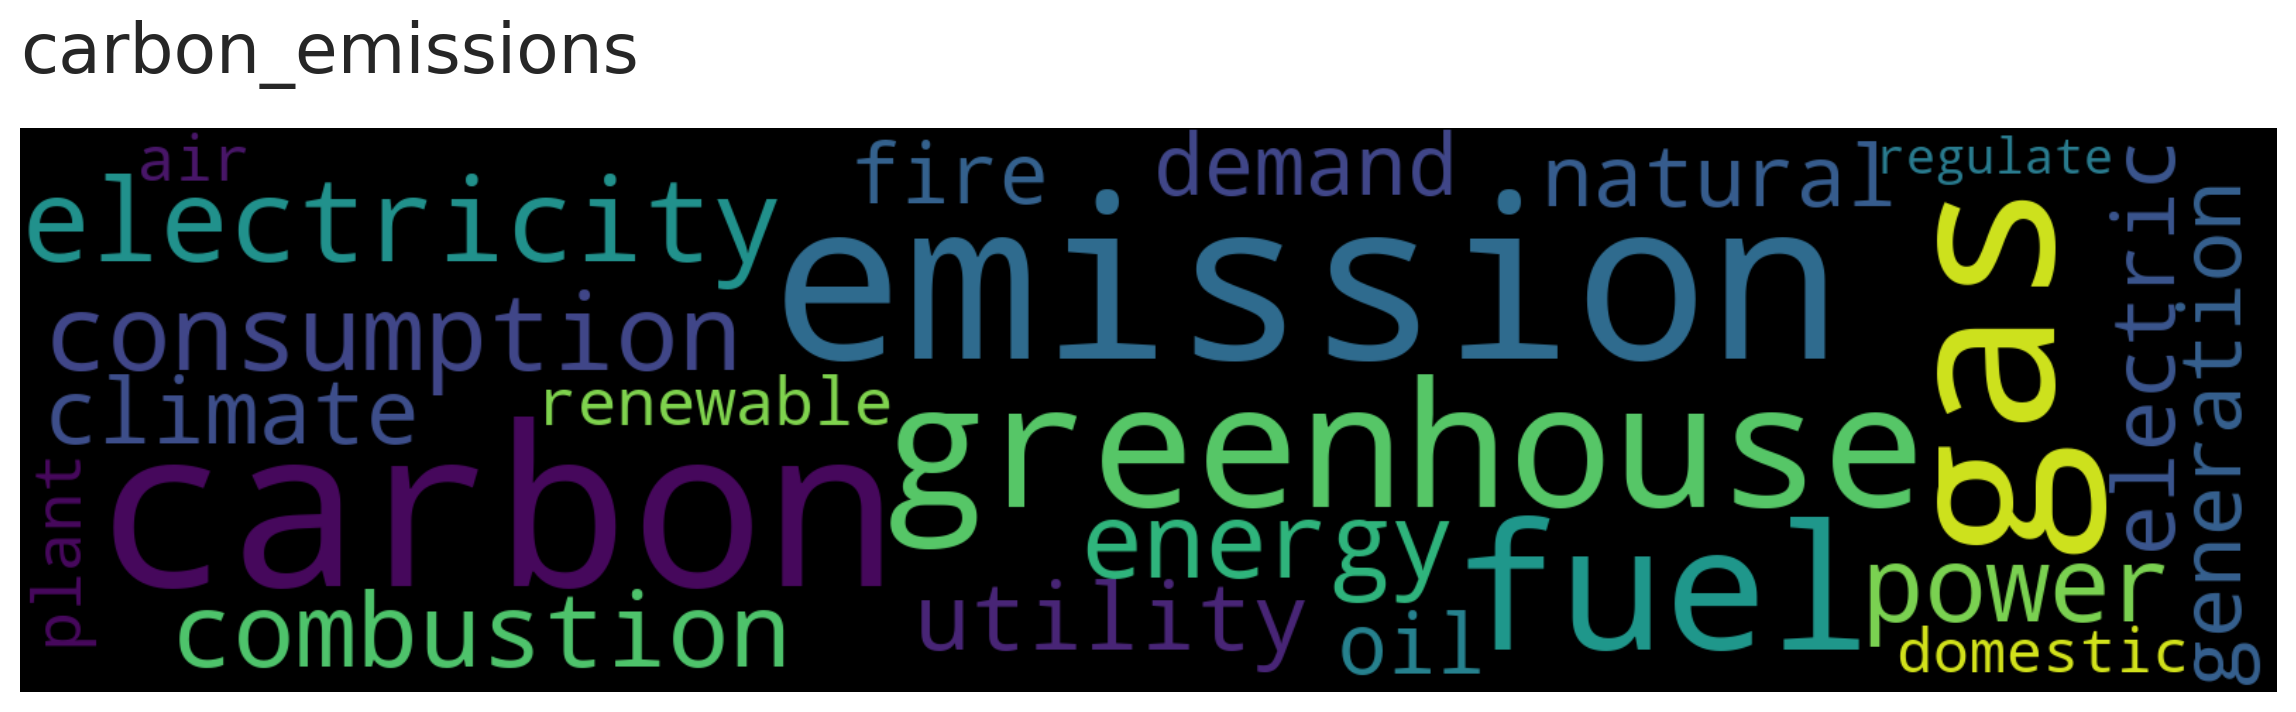

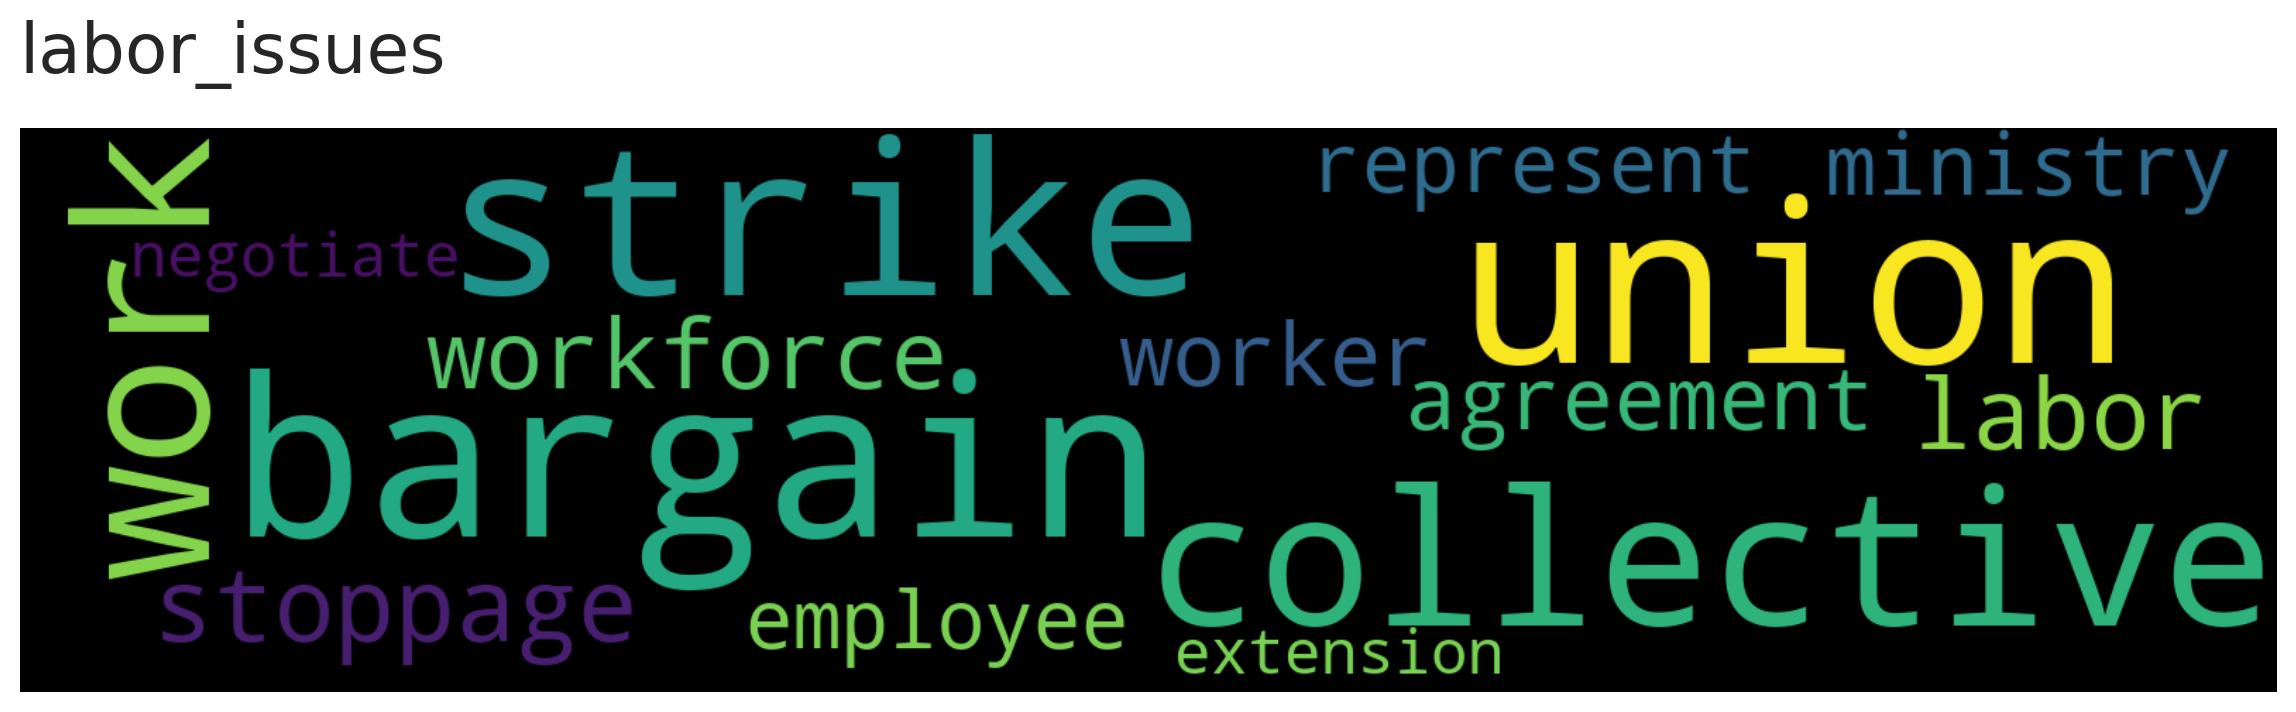

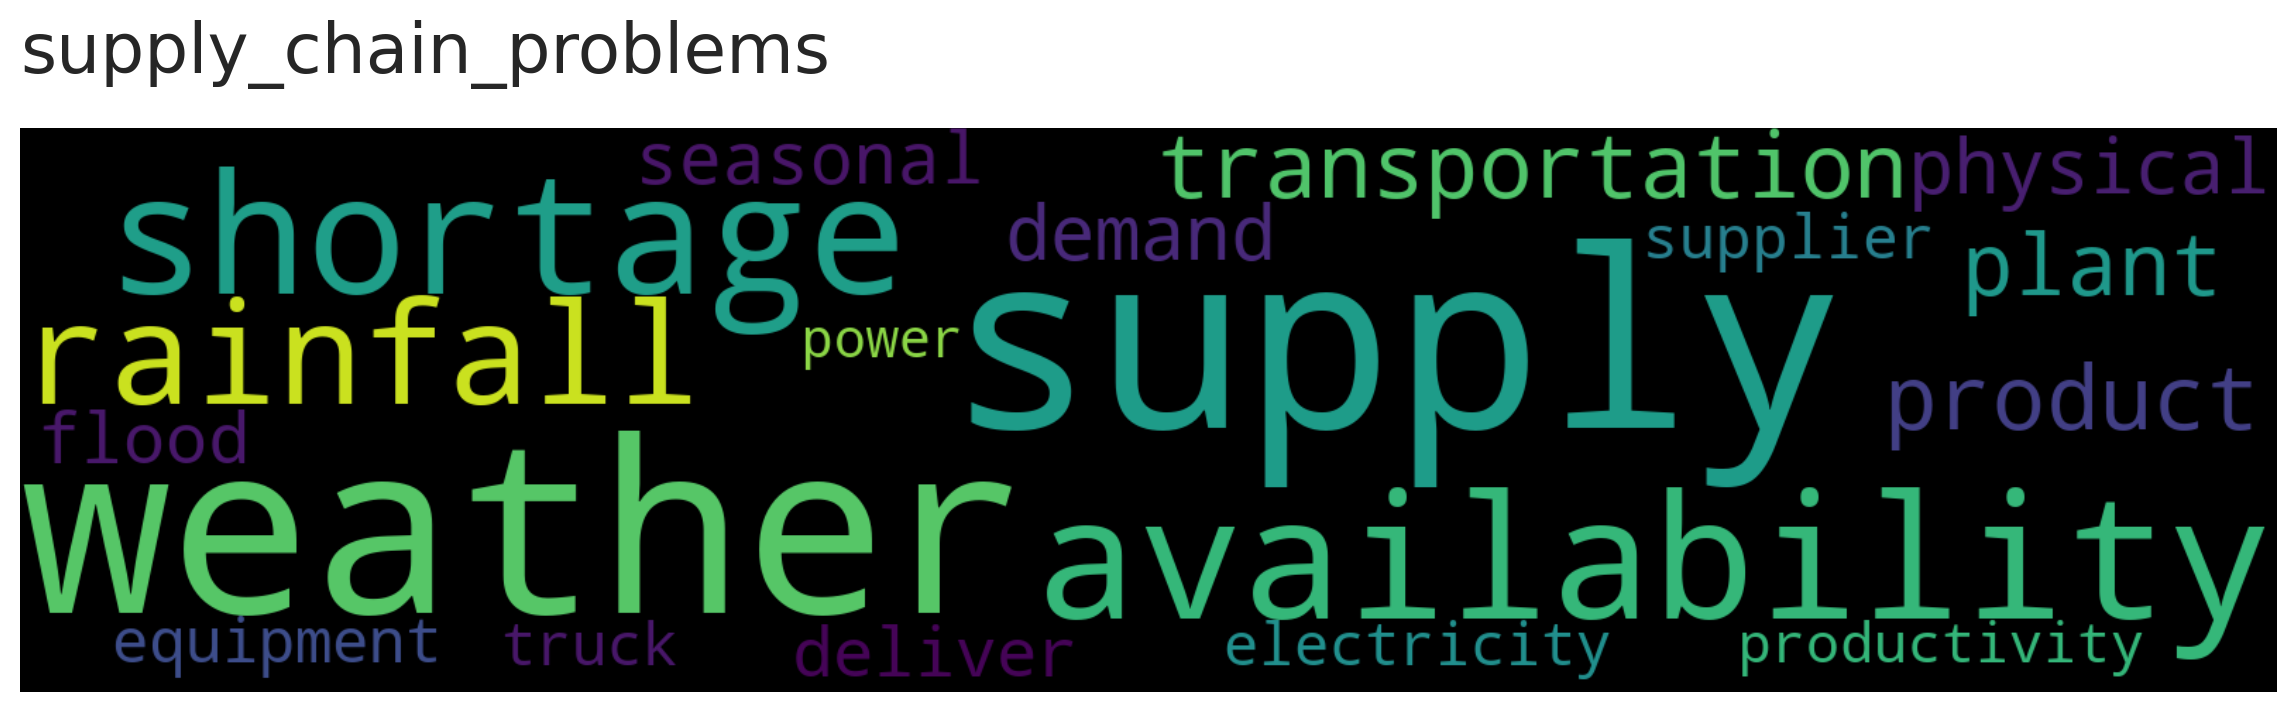

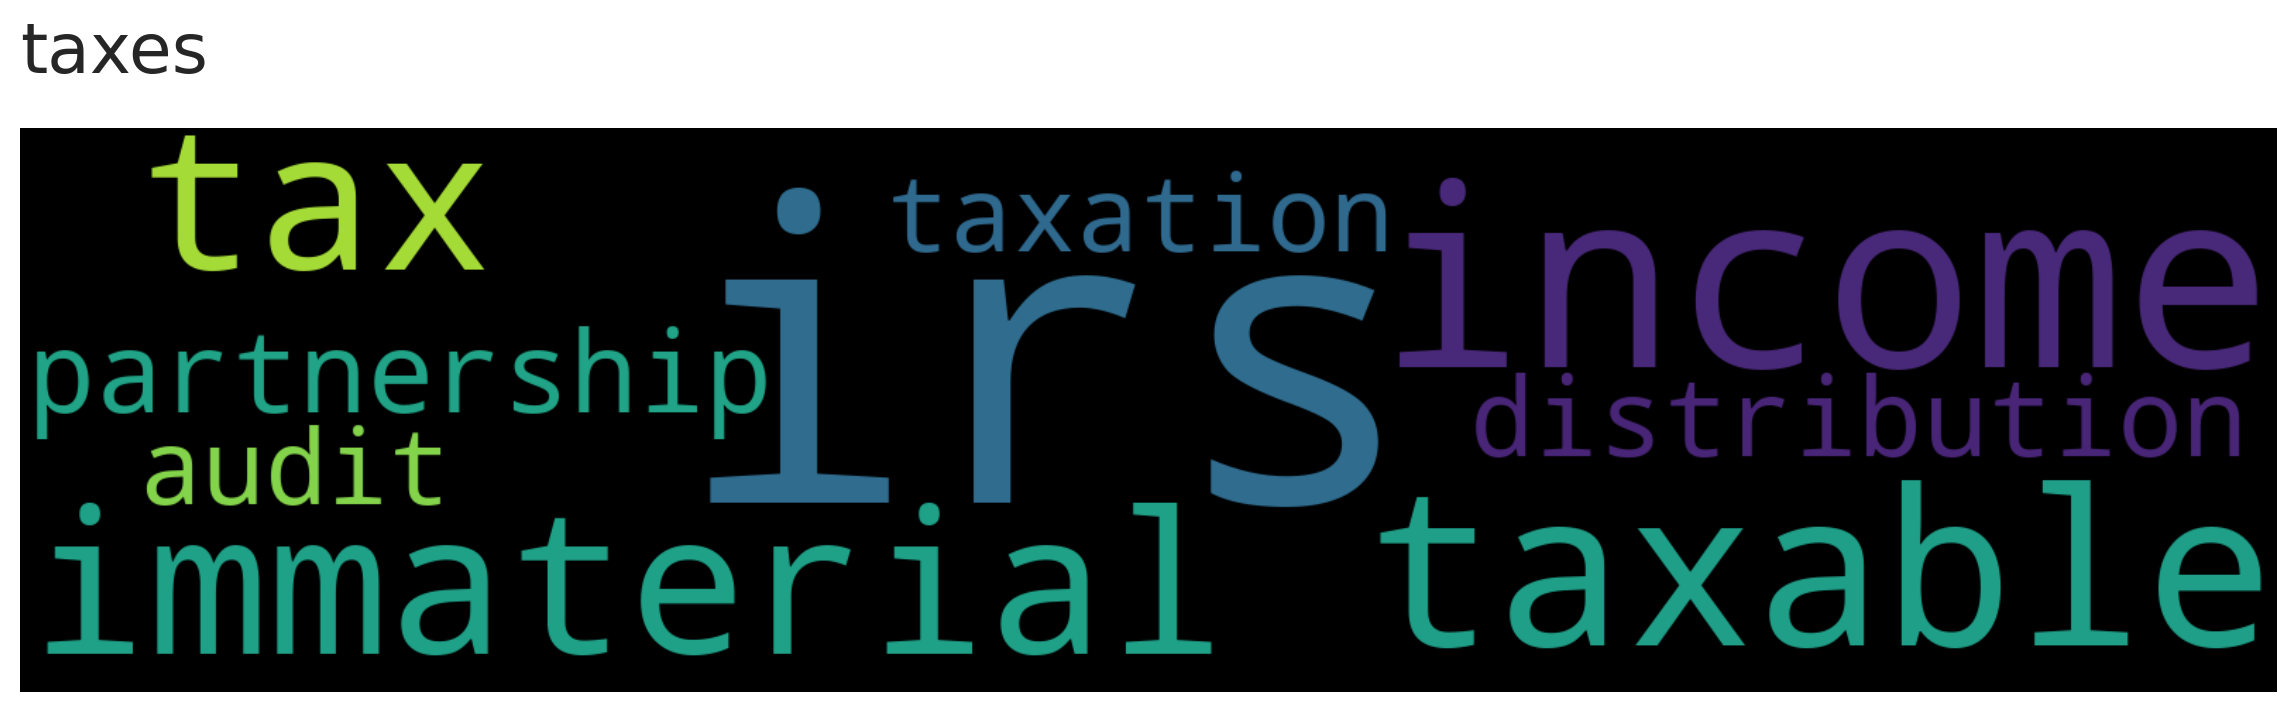

In [8]:
# Re-generate wordclouds for the trimmed topics
for tid in topic_words["topic_num"].unique():
    topic_word_freq = {row.keyword: row.cosine_score for row in 
                            topic_words.loc[topic_words["topic_num"] == tid].itertuples()}
    generate_wordcloud(topic_word_freq, topic_itos_cluster[tid])

In [12]:
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

# Augment word list using fasttext embeddings
for i in range(len(topic_bags)):
    topic_bags[i] = get_similar_words_fasttext(topic_bags[i], top_k=50, thresh=0.64) + topic_bags[i]

In [14]:
# Load re-trimmed augmented topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_cluster_aug_to_trim_th.csv")
topic_words = topic_words.loc[topic_words["drop_th"] != 1]
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_cluster.items()):
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

Topic ( 4 - customer_orientation): sales, business, price, products, industry, company, supplier, prices, marketing, profits, investment, markets, production, buyer, pricing, commodity, seller, suppliers, manufacturing, profit, customers, consumer, enterprise, revenues, goods, commercial, selling, purchaser, retailer, brand, trade, competitors, customer, demand, sale, margin, revenue, product, manufacturer, retail, downturn, competitor, producer, supply, competition, sell, domestic, profitability, market
Topic ( 6 - shareholder_affiliation): corporation, shareholder, business, company, shareholders, directors, partners, investment, agreement, executive, management, election, government, director, incorporation, stockholder, certificate, partner, officer, vote, merger, affiliate, unitholders, partnership, board, transaction, corporate, venture, elect, consent
Topic ( 8 - hiring_employees): staff, recruit, employ, hire, retain, skilled, personnel, executive, employee, experience
Topic ( 

In [23]:
predict_topic_fn = t2v_viewer.make_fasttext_keyword_predictor(topic_bags=topic_bags, thresh_matching=0.75)
df_test = df_transcript.sample(50, random_state=42).copy()
df_test["topic_ids"] = df_test["component_text_sentences"].progress_apply(lambda ss: predict_topic_fn(ss, thresh=1.5))

100%|██████████| 50/50 [00:00<00:00, 67.81it/s]


In [24]:
samples = []
for ss, tss in zip(df_test["component_text_sentences"], df_test["topic_ids"]):
    for s, ts in zip(ss, tss):
        topic_names = []
        for t in ts:
            if t >= 0:
                topic_names.append(topic_itos_cluster[topic_words.topic_num.unique()[t]])
        if topic_names:
            samples.append({"tag_names": ", ".join(topic_names), "sentence": s})

for s in samples:
    pprint(s["sentence"])
    print(f'- {s["tag_names"]}', end="\n\n")

'The energy storage facility, an amazing piece of equipment.'
- supply_chain_problems

('And what happens is, traditionally, we used our spinning reserve, our diesel '
 'generators, high-speed generators, to be able to supply the immediate demand '
 'when we hoisted -- we turned on the shaft hoist motors or we turn on the big '
 'mills or whatever.')
- customer_orientation, carbon_emissions

('And then the battery behaves as a responsive provider of energy for those '
 'quick demands.')
- carbon_emissions

("The first thing we measured was the impact on fuel, as you've seen, and we "
 'shared that with you as well as greenhouse gas emissions.')
- carbon_emissions

('And so any way we can harness that hydropower station and reduce the '
 'consumption of diesel hits the bottom line, and we expect that to continue.')
- carbon_emissions

("And by using that [indiscernible] enforcing effect, as you've seen from some "
 'of the government announcements, it basically says that we cannot chang

In [25]:
pd.DataFrame(samples).to_csv(paths.home / "tmp" / "topic-cluster-samples-transcripts.csv", index=False)

In [ ]:
# Load pillar topic words
topic_words = pd.read_excel(paths.data / "topics" / "MSCI keywords.xlsx", usecols=["Pillar", "Keywords"]) \
                .fillna(method="ffill") \
                .rename(columns={"Keywords": "keyword", "Pillar": "topic_name"}) \
                .apply(lambda x: x.str.lower().str.strip()) \
                .assign(topic_num=lambda x: x["topic_name"].map(lambda t: topic_stoi_pillar[t])) \
                .groupby(["topic_num", "topic_name"]) \
                .agg({"keyword": lambda x: re.split(", | ", ", ".join(x))}) \
                .reset_index()

topic_bags = topic_words.sort_values("topic_num")["keyword"].values.tolist()
for i in range(len(topic_bags)):
    topic_bags[i] = get_similar_words_fasttext(topic_bags[i], thresh=0.64) + topic_bags[i]

In [34]:
# Load BBK topic words
topic_words_bbk = pd.read_excel(paths.data / "topics" / "BaierBerningerKiesel_ESG-Wordlist_2020_July22.xlsx", sheet_name="ESG-Wordlist") \
                    .rename(columns={"Word": "keyword", "Topic": "topic_name"}) \
                    .apply(lambda x: x.str.lower().str.strip()) \
                    .assign(topic_num=lambda x: x["topic_name"].map(lambda t: topic_stoi_pillar[t])) \
                    .loc[:, ["topic_num", "topic_name", "keyword"]]

# Load re-trimmed augmented topic words
topic_words = pd.read_csv(paths.data / "topics" / "topic_words_pillar_aug_to_trim_th.csv")
topic_words = topic_words.loc[topic_words["drop_th"] != 1, ["topic_num", "topic_name", "keyword"]]
topic_words = pd.concat([topic_words, topic_words_bbk], ignore_index=True).reset_index(drop=True)

# Construct topic bags
topic_bags = topic_words[["topic_num", "keyword"]] \
                .groupby("topic_num") \
                .agg(list) \
                .reset_index() \
                .sort_values("topic_num")["keyword"] \
                .values.tolist()

for i, (tn, ti) in zip(range(len(topic_bags)), topic_stoi_pillar.items()):
    print(f"Topic ({ti:2d} - {tn}): {', '.join(topic_bags[i])}")

Topic ( 0 - environmental): ecological, environment, nature, health, ecology, resource, conservation, sustainability, carbon, emissions, carbon, carbon, clean, energy, carbon, carbon, environmental, green, climate, climate, environmental, environmental, water, water, water, biodiversity, land, ecosystems, marine, biodiversity, agricultural, sustainable, aquaculture, timber, toxic, emissions, toxic, water, pollution, contamination, carcinogens, smog, waste, recycling, waste, clean, environmental, green, environmental, green, green, sustainable, renewable, energy, alternative, energy, energy, efficiency, wind, energy, solar, energy, biomass, energy, hydro, energy, smart, hybrid, carbon, clean, environmental, epa, sustainability, climate, warming, biofuel, biofuels, green, renewable, solar, stewardship, wind, atmosphere, emission, emissions, emit, ghg, ghgs, greenhouse, agriculture, deforestation, pesticide, pesticides, wetlands, zoning, biodiversity, species, wilderness, wildlife, freshw

In [41]:
predict_topic_fn = t2v_viewer.make_fasttext_keyword_predictor(topic_bags=topic_bags, thresh_matching=0.75)
df_test = df_transcript.sample(50, random_state=42).copy()
df_test["topic_ids"] = df_test["component_text_sentences"].progress_apply(lambda ss: predict_topic_fn(ss, thresh=1.5))

100%|██████████| 50/50 [00:01<00:00, 43.53it/s]


In [42]:
samples = []
for ns, ss, tss in zip(df_test["is_noise_probas"], df_test["component_text_sentences"], df_test["topic_ids"]):
    for n, s, ts in zip(ns, ss, tss):
        if n < 0.5:
            topic_names = []
            for t in ts:
                if t >= 0:
                    topic_names.append(topic_itos_pillar[topic_words.topic_num.unique()[t]])
            if topic_names:
                samples.append({"tag_names": ", ".join(topic_names), "sentence": s})

for s in samples:
    pprint(s["sentence"])
    print(f'- {s["tag_names"]}', end="\n\n")

("The first thing we measured was the impact on fuel, as you've seen, and we "
 'shared that with you as well as greenhouse gas emissions.')
- environmental

("We see, after we've received -- or once we receive the consents to acquire "
 'those assets, we would see a path to rectify all of the shortcomings, I '
 'would say, linked to the concessions and [ instrument approvals ].')
- governance

("As you've seen in the press in the last couple of days, the government has "
 "indicated that they're going to extend our contract and they're going to use "
 'the export license.')
- governance

("And by using that [indiscernible] enforcing effect, as you've seen from some "
 'of the government announcements, it basically says that we cannot change '
 'anything-- the reason that we have stayed in our current process [ph], is '
 'before we make any kind of concessions or the government makes any kind of '
 "concessions, we're trying to end up with a win-win situation, and that's "
 'where this

In [43]:
pd.DataFrame(samples).to_csv(paths.home / "tmp" / "topic-pillar-samples-transcripts.csv", index=False)

In [47]:
from gensim.models import KeyedVectors

fasttext_model = None
if fasttext_model is None:
    fasttext_path = paths.model / "fasttext" / "wiki-news-300d-1M.vec"
    fasttext_model = KeyedVectors.load_word2vec_format(str(fasttext_path), binary=False)


### __Predict if Sentence is Noise__

This model help determine if the input (transcript) text is noise like greetings or transitions.

In [ ]:
predict_noise_fn = make_setfit_binary_predictor(str(paths.model / "sentence-transformers/all-mpnet-base-v2-denoise"))
df_transcript["is_noise_probas"] = df_transcript["component_text_sentences"].progress_apply(lambda ss: predict_noise_fn(ss, return_probas=True))

In [ ]:
# Free up CUDA memory
del predict_noise_fn

### __Predict if Describing an Action Taken__

In [ ]:
predict_action_fn = make_setfit_binary_predictor(str(paths.model / "sentence-transformers/all-MiniLM-L12-v2-actions-aug"))
df_transcript["is_action_probas"] = df_transcript["component_text_sentences"].progress_apply(lambda ss: predict_action_fn(ss, return_probas=True))

In [19]:
samples = []
for row in df_transcript.sample(100, random_state=42).itertuples():
    for n, s, a in zip(row.is_noise_probas, row.component_text_sentences, row.is_action_probas):
        if n < 0.5:
            samples.append((a, s.replace("\n", "")))
samples.sort(key=lambda x: x[0], reverse=True)
for s in samples[:300]:
    print(f"[ {s[0]:.2f} ] {s[1]}")

[ 1.00 ] We have been patient and supportive of the project and that strategy has now paid off.
[ 0.99 ] We are continuing to deliver on our strategy, which we clearly set out a little over 2 years ago.
[ 0.99 ] We have initiated project studies at La Coipa and Lobo Marte and we continue to advance our exploration program.
[ 0.99 ] Hamilton Beach continues to focus on strengthening its North American consumer market position through product innovation, promotions, increased placements and branding programs, together with appropriate levels of advertising for the company's highly successful and innovative product lines.
[ 0.99 ] We recognized record revenue and cash flow during the year and continued to execute on our long-term growth plan by adding quality, long-life royalties to our portfolio.
[ 0.99 ] Hamilton Beach continues to monitor both currency effects and commodity costs closely and intends to adjust prices and product placements appropriately in response to such cost increase

In [ ]:
# Free up CUDA memory
del predict_action_fn

In [ ]:
transcript_loader.flush_processed(df_transcript, "transcript_with_attributes.json")

## __Compute Statistics__

In [ ]:
def compute_statistics(row: pd.Series) -> pd.Series:

    def get_num_sentences_with_topic(topic_id: int) -> Tuple[int, int]:

        num = 0
        num_action = 0
        for topic_tags, is_noise_proba, is_action_proba in \
            zip(row["topic_ids"], row["is_noise_probas"], row["is_action_probas"]):

            if is_noise_proba > 0.5:
                continue

            if topic_id in topic_tags:
                num += 1
                num_action += int(is_action_proba > 0.02)
        return num, num_action
    
    ret = {}
    ret["component_text_keep"] = ";\n".join([s for s, p in zip(row["component_text_sentences"], row["is_noise_probas"]) if p <= 0.5])
    ret["component_text_action"] = ";\n".join([s for s, pn, pa in zip(row["component_text_sentences"], row["is_noise_probas"], row["is_action_probas"]) if pa > 0.02 and pn <= 0.5])

    ret["n_sentences"] = len(row["component_text_sentences"])
    ret["n_noise"]     = np.sum(np.array(row["is_noise_probas"]) > 0.5)
    ret["n_keep"]      = ret["n_sentences"] - ret["n_noise"]
    ret["n_action"]    = np.logical_and(np.array(row["is_action_probas"]) > 0.02, np.array(row["is_noise_probas"]) <= 0.5).sum()

    for topic, topic_id in topic_stoi.items():
        ret[f"n_topic_{topic}"], ret[f"n_topic_action_{topic}"] = get_num_sentences_with_topic(topic_id)
    return pd.Series(ret)

In [ ]:
df_transcript = df_transcript.reset_index(drop=True)
df_statistics = df_transcript.progress_apply(compute_statistics, axis=1)
df_statistics = pd.concat([df_transcript, df_statistics], axis=1)
df_statistics.head()

In [ ]:
df_statistics.head(2048).to_excel(paths.stats / "transcript_statistics_sample.xlsx", index=False)
df_statistics.to_excel(paths.stats / "transcript_statistics.xlsx", index=False)

In [ ]:
df_transcript_topic_dist = (
    df_transcript
        .explode("topic_ids")
        .explode("topic_ids")  # Need a second explode since the first one creates a list of lists
        .groupby(transcript_loader.id_columns)["topic_ids"]
        .value_counts(normalize=False)
        .unstack(fill_value=0)
        .add_prefix("topic_reduced_")
        .reset_index()
        .rename_axis(None, axis=1)
        .assign(total_sentence_count=lambda x: x.filter(regex="topic_reduced_").sum(axis=1))
)
df_transcript_topic_dist.head()

In [ ]:
# df_transcript.to_excel(paths.stats / "transcript_topic_tags.xlsx", index=False)
# df_transcript_topic_dist.to_csv(paths.stats / "transcript_topic_distribution.csv", index=False)